- 좀 더 많은 피처를 가진 데이터 세트를 적은 PCA 컴포넌트 기반으로 변환한 뒤, 예측 영향도가 어떻게 되는지 변환된 PCA 데이터 세트에 기반해서 비교해보자

In [3]:
# header로 의미 없는 첫 행 제거, iloc로 기존 id 제거
import pandas as pd

df = pd.read_excel('data/credit_card.xls', header=1, sheet_name='Data').iloc[0:, 1:]
print(df.shape)
df.head(3)

(30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


- 30,000개의 레코드와 24개의 속성
- 'default payment next month' 속성이 Target 값으로 '다음달 연체 여부'를 의미
    - '연체'일 경우 1, '정상납부'일 경우 0
- PAY_0 다음에 PAY_2 칼럼이 있으므로 PAY_0 칼럼을 PAY_1으로 칼럼명을 변환하고 'default payment next month' 칼럼도 'default'로 변경


In [4]:
df.rename(columns={'PAY_0':'PAY_1', 'default payment next month':'default'}, inplace=True)
y_target = df['default']
X_features = df.drop('default', axis=1)

- 해당 데이터 세트는 23개의 속성 데이터 세트가 있으나 각 속성끼리 상관도가 매우 높음
- corr()를 이용해 각 속성 간의 상관도를 구한 뒤 이를 Seaborn의 heatmap으로 시각화

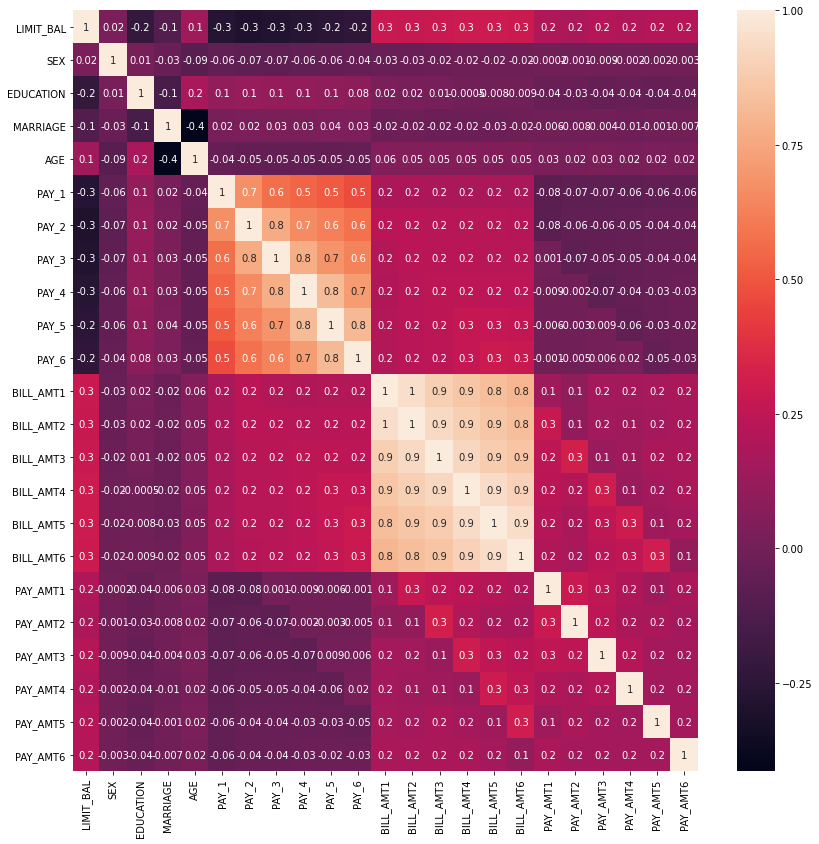

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

corr = X_features.corr()
plt.figure(figsize=(14, 14))
sns.heatmap(corr, annot=True, fmt='.1g')

- BILL_AMT1 ~ BILL_AMT6 6개 속성끼리의 상관도가 대부분 0.9 이상으로 매우 높음을 알 수 있음
- 이보다는 낮지만 PAY_1 ~ PAY_6까지의 속성 역시 상관도가 높음
- 높은 상관도를 가진 속성들은 소수의 PCA만으로도 자연스럽게 이 속성들의 변동성을 수용할 수 있음
- BILL_AMT1 ~ BILL_AMT6까지 6개 속성을 2개의 컴포넌트로 PCA 변환한 뒤 개별 컴포넌트의 변동성을 explained_variance_ratio_ 속성으로 알아보자

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# BILL_AMT1 ~ BILL_AMT6까지 6개의 속성명 생성
cols_bill = ['BILL_AMT'+str(i) for i in range(1, 7)]
print('대상 속성명: ', cols_bill)

# 2개의 PCA 속성을 가진 PCA 객체 생성하고, explained_variance_ratio_ 계산을 위해 fit() 호출
scaler = StandardScaler()
df_cols_scaled = scaler.fit_transform(X_features[cols_bill])
pca = PCA(n_components=2)
pca.fit(df_cols_scaled)
print('PCA Component별 변동성: ', pca.explained_variance_ratio_)

대상 속성명:  ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
PCA Component별 변동성:  [0.90555253 0.0509867 ]


- 단 2개의 PCA 컴포넌트만으로도 6개 속성의 변동성을 약 95% 이상 설명
    - 특히 첫 번째 PCA 축으로 90%의 변동성을 수용할 정도로 이 6개 속성의 상관도가 매우 높음

In [9]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rcf = RandomForestClassifier(n_estimators=300, random_state=156)
scores = cross_val_score(rcf, X_features, y_target, scoring='accuracy', cv=3)

print('CV=3인 경우의 개별 Fold 세트별 정확도: ', scores)
print('평균 정확도:{0:.4f}'.format(np.mean(scores)))

CV=3인 경우의 개별 Fold 세트별 정확도:  [0.8083 0.8196 0.8232]
평균 정확도:0.8170


In [12]:
# 원본 데이터 세트에 먼저 StandardScaler 적용
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X_features)

# 6개의 컴포넌트를 가진 PCA 변환을 수행하고 cross_val_score()로 분류 예측 수행
pca = PCA(n_components=6)
df_pca = pca.fit_transform(df_scaled)
scores_pca = cross_val_score(rcf, df_pca, y_target, scoring='accuracy', cv=3)

print('CV=3인 경우의 PCA 변환된 개별 Fold 세트별 정확도: ', scores_pca)
print('PCA 변환 데이터 세트 평균 정확도:{0:.4f}'.format(np.mean(scores_pca)))

CV=3인 경우의 PCA 변환된 개별 Fold 세트별 정확도:  [0.7924 0.7963 0.8029]
PCA 변환 데이터 세트 평균 정확도:0.7972


- 전체 23개 속성의 약 1/4 수준인 6개의 PCA 컴포넌트만으로도 원본 데이터를 기반으로 한 분류 예측 결과보다 약 1~2%정도의 예측 성능 저하만 발생
- 1~2%의 예측 성능 저하는 미비한 성능 저하로 보기는 힘듭니다만, 전체 속성의 1/4 정도만으로도 이정도 수치의 예측 성능을 유지할 수 있다는 것은 PCA의 뛰어난 압축 능력을 잘 보여준느 것이라 생각됨
- PCA는 차원 축소를 통해 데이터를 쉽게 인지하는 데 활용할 수 있다만, 이보다 더 활발하게 적용되는 영역은 컴퓨터 비전(Computer Vision)분야
    - 특히 얼굴 인식의 경우 Eigen-face라고 불리는 PCA 변환으로 원본 얼굴 이미지를 변환해 사용하는 경우 많음